In [1]:
import os
import sys

import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import pandas as pd
sns.set(style='whitegrid', rc={
    'figure.figsize':(12,8),
    'legend.fontsize': 'large',
    'legend.title_fontsize': 'large',
    'axes.labelsize': 'large',
    'axes.titlesize':'large',
    'xtick.labelsize':'medium',
    'ytick.labelsize':'medium',
    'font.family': 'sans-serif',
    'font.sans-serif': 'Lucida Grande'
})

from simulated_utils import compare
from simulated_utils import TwoPeakCtsBanditEnv

In [2]:
def filter_df(df, **kwargs):
    for k,v in kwargs.items():
        df = df[df[k] == v]
    return df

In [3]:
env = TwoPeakCtsBanditEnv(noise_std=0.001)
data_gaussian = compare(env, 'gaussian', n_steps=10, repeats=1,
               lr=1e-1, batch_size=16*32, num_minibatches=16, ppo_epochs=20)
data_gaussian['mean'] = data_gaussian['pd_param_0_mean']
data_gaussian['std'] = data_gaussian['pd_param_1_mean']

/home/eecs/chloehsu/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [69]:
env = TwoPeakCtsBanditEnv(noise_std=0.001)
from gym.spaces.box import Box as Continuous
env.action_space = Continuous(low=np.array([-5]), high=np.array([5]), dtype=np.float32)
data_beta = compare(env, 'beta', n_steps=10, repeats=1,
               lr=1e-1, batch_size=16*32, num_minibatches=16, ppo_epochs=20)

/home/eecs/chloehsu/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [70]:
a = data_beta['pd_param_0_mean']
b = data_beta['pd_param_1_mean']
data_beta['mean'] = (a / (a+b)) * 10 - 5
#data_beta['std'] = data_beta['pd_param_1_mean']

In [4]:
def get_two_peak_reward(action):  
    reward = 1.1 * np.exp(-1.2*np.power(action-(-2), 2)) + 0.9 * np.exp(-0.9*np.power(action-(1), 2))
    return reward

In [6]:
%matplotlib inline

18.19949646762079


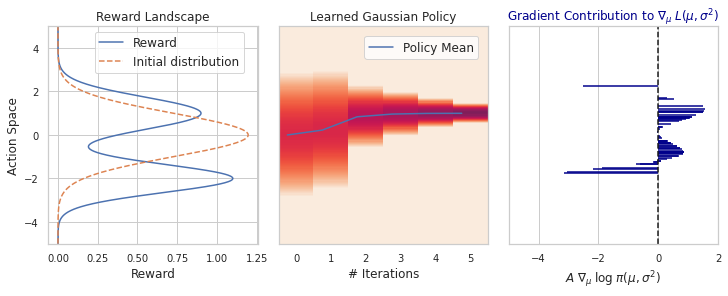

In [67]:
from scipy.stats import norm
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=False)
y1 = -5
y2 = 5
niters = 6
nbins = 201
x = np.linspace(y1, y2, 1000)
axes[0].set_ylim([y1, y2])
axes[0].set_ylabel('Action Space')
axes[0].set_title('Reward Landscape')
axes[0].set_xlabel('Reward')
axes[0].plot(np.vectorize(get_two_peak_reward)(x), x,
             linestyle='-', label='Reward', alpha=1)
axes[0].plot(3 * norm(0,1).pdf(x), x,
             linestyle='--', label='Initial distribution', alpha=1)
axes[1].set_ylim([y1, y2])
ax1_twin = axes[1].twinx()
ax1_twin.set_ylim([y1, y2])
x = np.linspace(y1, y2, nbins)
binwidth = (x[1]-x[0])
heatmap = np.zeros((niters, nbins))
for i in range(niters):
    mean = filter_df(data_gaussian, iter=i, method='Clipping')['mean'].values.item()
    std = filter_df(data_gaussian, iter=i, method='Clipping')['std'].values.item()
    rv = norm(loc=mean, scale=std)
    heatmap[i, :] = np.log(1e-6 + rv.cdf(x + binwidth/2) - rv.cdf(x - binwidth/2))
#yticklabels = [xx.round(2) if i % 5 == 0 else ''  for i, xx in enumerate(x)]
sns.heatmap(np.flip(heatmap.T, axis=0), ax=axes[1], square=False, cmap=sns.cm.rocket_r, vmin=-8, vmax=1.0,
            cbar=False, annot=False)
ax1_twin.plot(data_gaussian[(data_gaussian.method == 'Clipping') & (data_gaussian.iter < niters)].iter + 0.25,
              data_gaussian[(data_gaussian.method == 'Clipping') & (data_gaussian.iter < niters)]['mean'],
              label='Policy Mean')
#ax1_twin.hlines(2.5, 0, 20, color='black')
axes[1].get_yaxis().set_ticks([])
axes[1].set_title('Learned Gaussian Policy')
axes[1].set_xlabel('# Iterations')
ax1_twin.set_yticks([])


mu = 0
sigma = 1
rvnorm = norm(loc=mu, scale=sigma)
x_normsamples = np.sort(rvnorm.rvs(64))
rewards = np.vectorize(get_two_peak_reward)(x_normsamples)
# grad_mu (log pi(theta))
smu = (x_normsamples - mu) / (sigma ** 2)
# policy gradient on mu
gradmu = (rewards - np.mean(rewards)) / np.std(rewards) * smu
print(np.sum(gradmu))
ax_guassian_grad = axes[2]
#ax_beta_grad.plot(x, gradmu, linestyle='-', label=r'Gradient contribution to $\frac{\partial}{\partial\mu}L(\mu, \sigma^2)$', color='coral')
for i in range(len(x_normsamples)):
    ax_guassian_grad.hlines(x_normsamples[i], 0, gradmu[i], color='darkblue')
ax_guassian_grad.set_xlabel(r'$A\;\nabla_{\mu}\; \log\;\pi(\mu,\sigma^2)$',labelpad=5)
ax_guassian_grad.set_title(r'Gradient Contribution to $\nabla_\mu\;L(\mu,\sigma^2)$', color='darkblue')
ax_guassian_grad.vlines(0, -5, 5, ls='--')
#ax_guassian_grad.set_ylabel('Action Space')
ax_guassian_grad.set_xlim([-5, 2])
ax_guassian_grad.set_ylim([-5, 5])
ax_guassian_grad.set_yticks([])


fig.align_ylabels(axes)
fig.subplots_adjust(wspace=0.1)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.13, 0.75), ncol=1)
handles, labels = ax1_twin.get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.5, 0.8), ncol=1)
plt.show()

-5.245432603595404
5.245432603595406


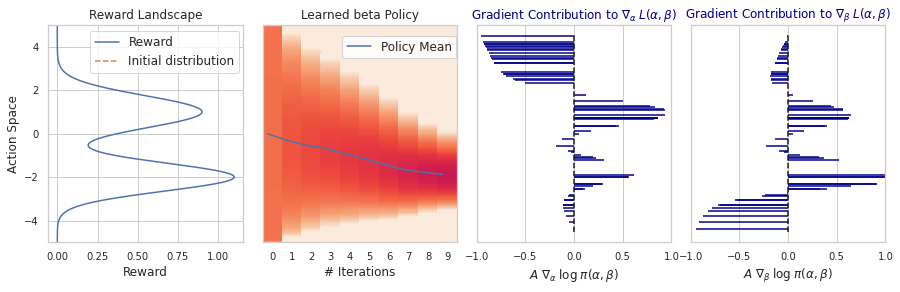

In [85]:
from scipy.stats import beta
fig, axes = plt.subplots(1, 4, figsize=(15, 4), sharey=False)
y1 = -5
y2 = 5
niters = 10
nbins = 201
x = np.linspace(y1, y2, 1000)
axes[0].set_ylim([y1, y2])
axes[0].set_ylabel('Action Space')
axes[0].set_title('Reward Landscape')
axes[0].set_xlabel('Reward')
axes[0].plot(np.vectorize(get_two_peak_reward)(x), x,
             linestyle='-', label='Reward', alpha=1)
axes[0].plot(3 * beta(0,1).pdf(x), x,
             linestyle='--', label='Initial distribution', alpha=1)
axes[1].set_ylim([y1, y2])
ax1_twin = axes[1].twinx()
ax1_twin.set_ylim([y1, y2])
x = np.linspace(y1, y2, nbins)
binwidth = (x[1]-x[0])
heatmap = np.zeros((niters, nbins))
for i in range(niters):
    a = filter_df(data_beta, iter=i, method='Clipping')['pd_param_0_mean'].values.item()
    b = filter_df(data_beta, iter=i, method='Clipping')['pd_param_1_mean'].values.item()
    rv = beta(a, b, loc=y1, scale=y2-y1)
    heatmap[i, :] = np.log(1e-6 + rv.cdf(x + binwidth/2) - rv.cdf(x - binwidth/2))
#yticklabels = [xx.round(2) if i % 5 == 0 else ''  for i, xx in enumerate(x)]
sns.heatmap(np.flip(heatmap.T, axis=0), ax=axes[1], square=False, cmap=sns.cm.rocket_r, vmin=-8, vmax=1.0,
            cbar=False, annot=False)
ax1_twin.plot(data_beta[(data_beta.method == 'Clipping') & (data_beta.iter < niters)].iter + 0.25,
              data_beta[(data_beta.method == 'Clipping') & (data_beta.iter < niters)]['mean'],
              label='Policy Mean')
#ax1_twin.hlines(2.5, 0, 20, color='black')
axes[1].get_yaxis().set_ticks([])
axes[1].set_title('Learned beta Policy')
axes[1].set_xlabel('# Iterations')
ax1_twin.set_yticks([])


a = 1
b = 1
rvbeta = beta(a, b, scale=y2-y1, loc=y1)
x_betasamples = np.sort(rvbeta.rvs(64))
rewards = np.vectorize(get_two_peak_reward)(x_betasamples)
# grad_mu (log pi(theta))
salpha_uniform = (x_betasamples - y1) / (y2-y1)
# policy gradient on mu
gradalpha = (rewards - np.mean(rewards)) / np.std(rewards) * salpha_uniform
print(np.sum(gradalpha))
ax_beta_grad = axes[2]
#ax_beta_grad.plot(x, gradmu, linestyle='-', label=r'Gradient contribution to $\frac{\partial}{\partial\mu}L(\mu, \sigma^2)$', color='coral')
for i in range(len(x_betasamples)):
    ax_beta_grad.hlines(x_betasamples[i], 0, gradalpha[i], color='darkblue')
ax_beta_grad.set_xlabel(r'$A\;\nabla_{\alpha}\; \log\;\pi(\alpha,\beta)$',labelpad=5)
ax_beta_grad.set_title(r'Gradient Contribution to $\nabla_\alpha\;L(\alpha,\beta)$', color='darkblue')
ax_beta_grad.vlines(0, -5, 5, ls='--')
#ax_beta_grad.set_ylabel('Action Space')
ax_beta_grad.set_xlim([-1, 1])
#ax_beta_grad.set_ylim([-5, 5])
ax_beta_grad.set_yticks([])

sbeta_uniform = (y2 - x_betasamples) / (y2-y1)
# policy gradient on mu
gradbeta = (rewards - np.mean(rewards)) / np.std(rewards) * sbeta_uniform
print(np.sum(gradbeta))
ax_beta_grad = axes[3]
#ax_beta_grad.plot(x, gradmu, linestyle='-', label=r'Gradient contribution to $\frac{\partial}{\partial\mu}L(\mu, \sigma^2)$', color='coral')
for i in range(len(x_betasamples)):
    ax_beta_grad.hlines(x_betasamples[i], 0, gradbeta[i], color='darkblue')
ax_beta_grad.set_xlabel(r'$A\;\nabla_{\beta}\; \log\;\pi(\alpha,\beta)$',labelpad=5)
ax_beta_grad.set_title(r'Gradient Contribution to $\nabla_\beta\;L(\alpha,\beta)$', color='darkblue')
ax_beta_grad.vlines(0, -5, 5, ls='--')
#ax_beta_grad.set_ylabel('Action Space')
ax_beta_grad.set_xlim([-1, 1])
#ax_beta_grad.set_ylim([-5, 5])
ax_beta_grad.set_yticks([])


fig.align_ylabels(axes)
fig.subplots_adjust(wspace=0.1)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.1, 0.75), ncol=1)
handles, labels = ax1_twin.get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.38, 0.8), ncol=1)
plt.show()

AttributeError: 'NoneType' object has no attribute 'get_legend_handles_labels'

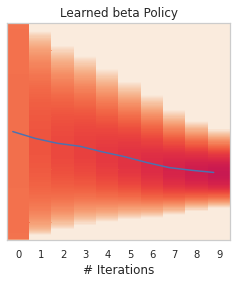

In [89]:
from scipy.stats import beta
fig, axes = plt.subplots(1, 1, figsize=(4, 4), sharey=False)
axes = [None, axes]
y1 = -5
y2 = 5
niters = 10
nbins = 201
x = np.linspace(y1, y2, 1000)
axes[1].set_ylim([y1, y2])
ax1_twin = axes[1].twinx()
ax1_twin.set_ylim([y1, y2])
x = np.linspace(y1, y2, nbins)
binwidth = (x[1]-x[0])
heatmap = np.zeros((niters, nbins))
for i in range(niters):
    a = filter_df(data_beta, iter=i, method='Clipping')['pd_param_0_mean'].values.item()
    b = filter_df(data_beta, iter=i, method='Clipping')['pd_param_1_mean'].values.item()
    rv = beta(a, b, loc=y1, scale=y2-y1)
    heatmap[i, :] = np.log(1e-6 + rv.cdf(x + binwidth/2) - rv.cdf(x - binwidth/2))
#yticklabels = [xx.round(2) if i % 5 == 0 else ''  for i, xx in enumerate(x)]
sns.heatmap(np.flip(heatmap.T, axis=0), ax=axes[1], square=False, cmap=sns.cm.rocket_r, vmin=-8, vmax=1.0,
            cbar=False, annot=False)
ax1_twin.plot(data_beta[(data_beta.method == 'Clipping') & (data_beta.iter < niters)].iter + 0.25,
              data_beta[(data_beta.method == 'Clipping') & (data_beta.iter < niters)]['mean'],
              label='Policy Mean')
#ax1_twin.hlines(2.5, 0, 20, color='black')
axes[1].get_yaxis().set_ticks([])
axes[1].set_title('Learned beta Policy')
axes[1].set_xlabel('# Iterations')
ax1_twin.set_yticks([])

fig.subplots_adjust(wspace=0.1)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.1, 0.75), ncol=1)
handles, labels = ax1_twin.get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.38, 0.8), ncol=1)
plt.show()

In [87]:
data_beta

,iter,loss,mean_reward,pd_param_0_mean,pd_param_1_mean,method,mean
0,0.0,-0.041802,0.369753,1.018150,1.018150,Reverse KL,0.000000
1,1.0,-0.103517,0.359832,1.257570,1.273816,Reverse KL,-0.032090
2,2.0,-0.081483,0.425391,1.547058,1.651783,Reverse KL,-0.163692
3,3.0,-0.115275,0.451508,1.892269,2.173065,Reverse KL,-0.345355
4,4.0,-0.035426,0.507247,2.385187,2.783386,Reverse KL,-0.385211
5,5.0,-0.044542,0.530864,2.961122,3.429497,Reverse KL,-0.366455
6,6.0,-0.041003,0.535155,3.361958,4.343329,Reverse KL,-0.636817
7,7.0,0.003389,0.571894,3.860790,5.026013,Reverse KL,-0.655592
8,8.0,-0.010455,0.562712,4.108589,5.548315,Reverse KL,-0.745438
9,9.0,-0.024312,0.581907,4.519841,6.396836,Reverse KL,-0.859692


In [ ]:
env = TwoPeakCtsBanditEnv(noise_std=0.001)
data_beta = compare(env, 'beta', n_steps=10, repeats=1,
               lr=1e-1, batch_size=16*32, num_minibatches=16, ppo_epochs=10)

a = data_beta['pd_param_0_mean']
b = data_beta['pd_param_1_mean']
data_beta['mean'] = a / (a + b)
data_beta['std'] = (a * b / (a + b + 1)).apply(np.sqrt) / (a + b)
# Scale it to [-3,3]
data_beta['mean'] = data_beta['mean'] * 3 - 1.5
data_beta['std'] = data_beta['std'] * 3

In [6]:
%matplotlib inline

In [5]:
data_gaussian

,iter,loss,mean_reward,pd_param_0_mean,pd_param_1_mean,method,mean,std
0,0.0,-7.467447e-02,0.504718,0.000000,1.000000,Reverse KL,0.000000,1.000000
1,1.0,-5.998234e-02,0.516883,0.130708,0.949640,Reverse KL,0.130708,0.949640
2,2.0,4.216233e-03,0.544813,0.239176,0.776864,Reverse KL,0.239176,0.776864
3,3.0,-3.803444e-02,0.541296,0.190339,0.728313,Reverse KL,0.190339,0.728313
4,4.0,-5.056739e-02,0.560230,0.374747,0.600607,Reverse KL,0.374747,0.600607
5,5.0,-1.627910e-01,0.585742,0.427355,0.473504,Reverse KL,0.427355,0.473504
6,6.0,-1.195224e-02,0.604372,0.451142,0.375720,Reverse KL,0.451142,0.375720
7,7.0,-1.272905e-01,0.620845,0.489679,0.322165,Reverse KL,0.489679,0.322165
8,8.0,-1.169993e-01,0.635030,0.471372,0.252075,Reverse KL,0.471372,0.252075
9,9.0,-1.605434e-01,0.648021,0.499334,0.199195,Reverse KL,0.499334,0.199195


In [ ]:
import pickle
with open('double_peak_1d_gaussian.pkl', 'wb') as f:
    pickle.dump(data_gaussian, f)
with open('double_peak_1d_beta.pkl', 'wb') as f:
    pickle.dump(data_beta, f)

In [ ]:
def plot_results(data_gaussian, data_beta, n_boot=1000):
    fig, axes = plt.subplots(2, 3, figsize=(10, 6.5), sharex=True)
    fig.subplots_adjust(left=-0.4)
    sns.lineplot(data=data_gaussian, x='iter', y='mean_reward', hue='method', ax=axes[0][0], n_boot=n_boot)
    axes[0][0].set_title('Mean Reward')
    #axes[0][0].set_ylabel('Reward')
    axes[0][0].set_ylabel('')
    sns.lineplot(data=data_gaussian, x='iter', y='mean', hue='method', ax=axes[0][1], n_boot=n_boot)
    axes[0][1].set_title('Action Distribution, Mean')
    #axes[0][1].set_ylabel('Mean')
    axes[0][1].set_ylabel('')
    sns.lineplot(data=data_gaussian, x='iter', y='std', hue='method', ax=axes[0][2], n_boot=n_boot)
    axes[0][2].set_title('Action Distribution, Stddev')
    axes[0][2].set_ylabel('')
    axes[0][2].set_ylim([0,1])
    
    
    sns.lineplot(data=data_beta, x='iter', y='mean_reward', hue='method', ax=axes[1][0], n_boot=n_boot)
    #axes[1][0].set_ylabel('Mean Reward')
    axes[1][0].set_ylabel('')
    sns.lineplot(data=data_beta, x='iter', y='mean', hue='method', ax=axes[1][1], n_boot=n_boot)
    #axes[1][1].set_ylabel('Mean')
    axes[1][1].set_ylabel('')
    #axes[1][1].set_ylim([0,1])
    sns.lineplot(data=data_beta, x='iter', y='std', hue='method', ax=axes[1][2], n_boot=n_boot)
    #axes[1][2].set_ylabel('Stddev')
    #axes[1][2].set_ylim([0,1])
    axes[1][2].set_ylabel('')

    handles, labels = axes.flatten()[0].get_legend_handles_labels()
    for ax in axes.flatten():
        ax.get_legend().remove()
        ax.set_xlabel('# Iterations')
    fig.legend(handles[1:], labels[1:], loc='upper center', ncol=4)
    
    pad = 5
    ax = axes[0][0]
    ax.annotate('Gaussian Policy', xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                        xycoords=ax.yaxis.label, textcoords='offset points', rotation=90,
                        size='large', ha='right', va='center')
    ax = axes[1][0]
    ax.annotate('Beta Policy', xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                        xycoords=ax.yaxis.label, textcoords='offset points',
                        size='large', ha='right', va='center', rotation=90)
    plt.show()

In [6]:
%matplotlib inline

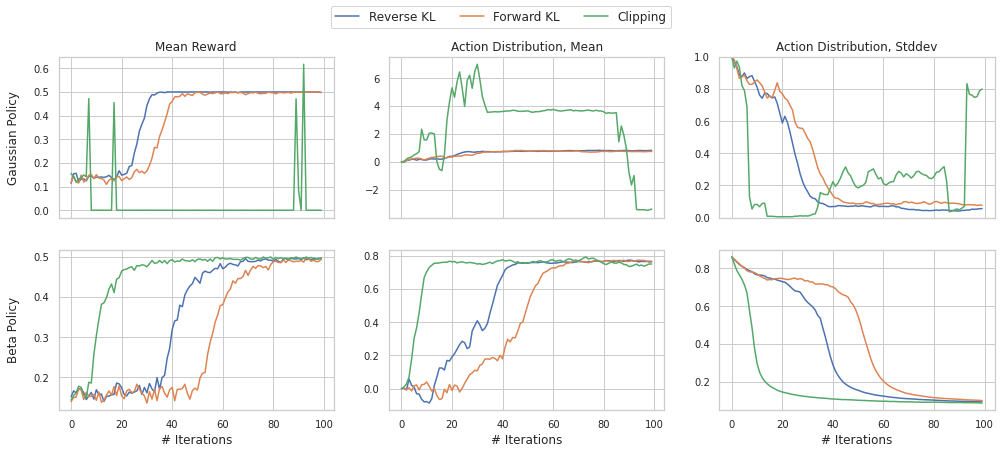

In [25]:
plot_results(data_gaussian[data_gaussian.method != 'Unregularized'],
             data_beta[data_beta.method != 'Unregularized'], n_boot=1000)

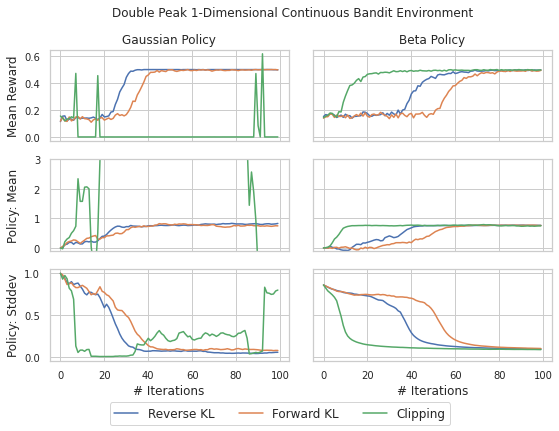

In [27]:
n_boot = 10

data_gaussian = data_gaussian[data_gaussian.method != 'Unregularized']
data_beta = data_beta[data_beta.method != 'Unregularized']

fig, axes = plt.subplots(3, 2, figsize=(9, 6), sharex=True, sharey='row')
sns.lineplot(data=data_gaussian, x='iter', y='mean_reward', hue='method', ax=axes[0][0], n_boot=n_boot)
axes[0][0].set_ylabel('Mean Reward')
sns.lineplot(data=data_gaussian, x='iter', y='mean', hue='method', ax=axes[1][0], n_boot=n_boot)
axes[1][0].set_ylabel('Policy: Mean')
axes[1][0].set_ylim([-0.1, 3])
sns.lineplot(data=data_gaussian, x='iter', y='std', hue='method', ax=axes[2][0], n_boot=n_boot)
axes[2][0].set_ylabel('Policy: Stddev')


sns.lineplot(data=data_beta, x='iter', y='mean_reward', hue='method', ax=axes[0][1], n_boot=n_boot)
sns.lineplot(data=data_beta, x='iter', y='mean', hue='method', ax=axes[1][1], n_boot=n_boot)
sns.lineplot(data=data_beta, x='iter', y='std', hue='method', ax=axes[2][1], n_boot=n_boot)

handles, labels = axes.flatten()[0].get_legend_handles_labels()
for ax in axes.flatten():
    ax.get_legend().remove()
    ax.set_xlabel('# Iterations')
fig.legend(handles[1:], labels[1:], loc='lower center', ncol=4)

axes[0][0].set_title('Gaussian Policy')
axes[0][1].set_title('Beta Policy')
fig.subplots_adjust(wspace=0.1, bottom=0.16)
fig.align_ylabels(axes[:, 0])

fig.suptitle('Double Peak 1-Dimensional Continuous Bandit Environment')
plt.show()

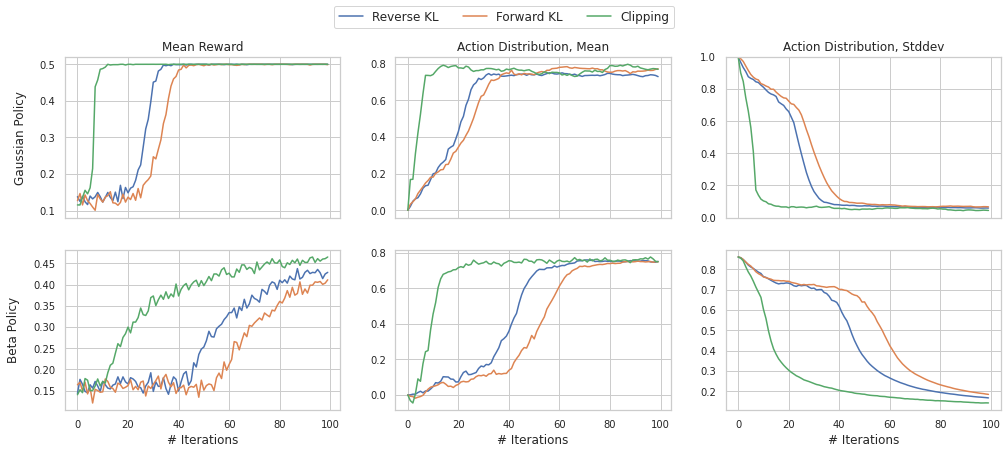

In [15]:
plot_results(data_gaussian[data_gaussian.method != 'Unregularized'],
             data_beta[data_beta.method != 'Unregularized'], n_boot=1000)

In [ ]:
%matplotlib inline